In [11]:
# built-in python modules
import os
import inspect
import datetime

# scientific python add-ons
import numpy as np
import pandas as pd
import locale

import matplotlib.pyplot as plt
import pvlib #das hier ist wichtig für PVlib simulation


import holidays
import seaborn as sns
import plotly
import plotly.graph_objects as go
import sys

import locale
from PIL import Image
from distutils.spawn import find_executable



from pvlib import clearsky
from pvlib import irradiance
from pvlib import atmosphere
from pvlib.location import Location

In [12]:
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 18
locale.setlocale(locale.LC_ALL, '')
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

if find_executable('latex'):
    plt.rcParams['text.usetex'] = True
    pd.set_option('display.latex.repr', True)
    pd.set_option('display.latex.longtable', True)

# Um PV-data zu erzegen, werden hier 2 Wege gezeigt:
**1. Durch Simulation** \
PVlib tutorials: https://www.youtube.com/channel/UCjAD9o5lavMVMqIrkcqOZ-g

**2. Data von DWD (Deutscher Wetterdienst)**

# 1. Durch Simulation

## Bestrahlungsstärke data für Simulation

In [13]:
# PVlib Doku: https://pvlib-python.readthedocs.io/en/stable/

# https://pvlib-python.readthedocs.io/en/v0.9.0/generated/pvlib.location.Location.html
tus = Location(50.9375, 6.9603, 'Europe/Berlin', 200, 'Tucson') 

#for times variation
times_loc = pd.date_range(start=datetime.datetime(2022,5,30), end=datetime.datetime(2022,6,5), 
                          freq='600s', tz=tus.tz)
#variable for the simulation
solpos = pvlib.solarposition.get_solarposition(times_loc, tus.latitude, tus.longitude)
dni_extra = pvlib.irradiance.get_extra_radiation(times_loc)
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(tus.altitude)
am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
cs = tus.get_clearsky(times_loc)

surface_tilt = tus.latitude
surface_azimuth = 180  # pointing south

#irradiance data
aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth,
                           solpos['apparent_zenith'], solpos['azimuth'])

#total irradiance data
total_irrad = pvlib.irradiance.get_total_irradiance(surface_tilt,
                                                    surface_azimuth,
                                                    solpos['apparent_zenith'],
                                                    solpos['azimuth'],
                                                    cs['dni'], cs['ghi'], cs['dhi'],
                                                    dni_extra=dni_extra,
                                                    model='haydavies')

## Solarmodul Auswählen

In [14]:
from pvlib import pvsystem
sandia_modules = pvsystem.retrieve_sam(name='SandiaMod')
sandia_modules

Advent_Solar_AS160___2006_  \
Vintage                                                        2006   
Area                                                          1.312   
Material                                                      mc-Si   
Cells_in_Series                                                  72   
Parallel_Strings                                                  1   
Isco                                                          5.564   
Voco                                                         42.832   
Impo                                                          5.028   
Vmpo                                                          32.41   
Aisc                                                       0.000537   
Aimp                                                      -0.000491   
C0                                                           1.0233   
C1                                                          -0.0233   
Bvoco                                                       -0.1703   
Mbvoc                                                             0   
Bvmpo                                                       -0.1731   
Mbvmp                                                             0   
N                                                             1.174   
C2                                                         -0.76444   
C3                                                         -15.5087   
A0                                                           0.9281   
A1                                                          0.06615   
A2                                                         -0.01384   
A3                                                         0.001298   
A4                                                        -0.000046   
B0                                                                1   
B1                                                        -0.002438   
B2                                                          0.00031   
B3                                                        -0.000012   
B4                                                              0.0   
B5                                                             -0.0   
DTC                                                             3.0   
FD                                                                1   
A                                                             -3.35   
B                                                           -0.1161   
C4                                                           0.9974   
C5                                                           0.0026   
IXO                                                            5.54   
IXXO                                                           3.56   
C6                                                            1.173   
C7                                                           -0.173   
Notes             Source: Sandia National Laboratories Updated 9...   

                                   Advent_Solar_Ventura_210___2008_  \
Vintage                                                        2008   
Area                                                          1.646   
Material                                                      mc-Si   
Cells_in_Series                                                  60   
Parallel_Strings                                                  1   
Isco                                                           8.34   
Voco                                                          35.31   
Impo                                                           7.49   
Vmpo                                                          27.61   
Aisc                                                        0.00077   
Aimp                                                       -0.00015   
C0                                                            0.937   
C1                                                            0.

In [15]:
## Moduleliste exportieren und von hier die passende Module auswählen

# Mit unterem Code kann man die CSV-Datei exportieren und mit Excel die Datei öffnen.

#sandia_modules.to_csv('sandia_modules.csv', index=False) 

### Daten von einer Module

In [16]:
# http://www.solardesigntool.com/components/module-panel-solar/Canadian-Solar/832/CS5P-220M/specification-data-sheet.html

sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                           -0.01284
Bvoco                                                        -0.21696
Mbvoc               

## PV-data simulieren

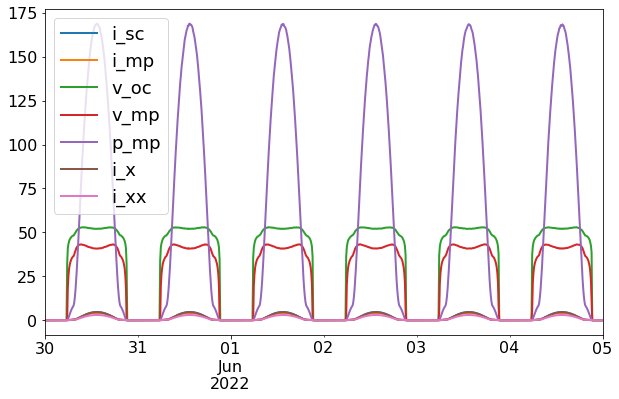

In [17]:
#SAPM Function is used

module = sandia_module

# a sunny, calm, and cool day
thermal_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

temps = pvlib.temperature.sapm_cell(total_irrad['poa_global'], 25, 0, **thermal_params)
a = np.random.rand(len(temps),) #random variable for temperature variance
temps = temps + a
temps.iloc[1442:2882,] = temps.iloc[1442:2882,]*1.1 #das Temperature ist 1.05 höher an zweitem Tag
temps.iloc[4323:7200,] = temps.iloc[4323:7200,]*0.8 #das Temperature von 4-6 ist 0.8 niedrieger

effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
    total_irrad['poa_direct'], total_irrad['poa_diffuse'],
    am_abs, aoi, module)

sapm = pvlib.pvsystem.sapm(effective_irradiance, temps, module)

sapm.plot();


In [18]:
# PV-Daten Exportieren

#sapm_1.to_csv('sapm.csv', index=False) 

# 2. Simulation mit data von DWD

In [19]:
# https://www.dwd.de/DE/leistungen/cdc/cdc_ueberblick-klimadaten.html

# 10Minuten Data köln
# Stations: 02667
# https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/recent/

# STATIONS_ID station identification number
# MESS_DATUM measurement time yyyymmddhh
# QN_9 quality level of next columns coding see paragraph "Quality information"
# TT_TU 2m air temperature ° C
# RF_TU 2m relative humidity %


# Koeln Air Temperature Data
df = pd.read_csv('../data/produkt_zehn_min_tu_20201205_20220607_02667.txt', sep=";") 
df

STATIONS_ID    MESS_DATUM    QN   PP_10  TT_10  TM5_10  RF_10  TD_10  \
0             2667  202012050000     3   980.1    3.9     2.5   89.8    2.4   
1             2667  202012050010     3   980.3    3.9     2.5   89.9    2.4   
2             2667  202012050020     3   980.3    3.8     2.6   90.3    2.4   
3             2667  202012050030     3   980.2    3.9     2.9   90.0    2.4   
4             2667  202012050040     3   980.2    4.0     3.0   89.1    2.4   
...            ...           ...   ...     ...    ...     ...    ...    ...   
79195         2667  202206072310     2  1000.6   14.6    13.8   94.7   13.8   
79196         2667  202206072320     2  1000.6   14.4    13.7   96.9   13.9   
79197         2667  202206072330     2  1000.6   14.0    13.4   96.9   13.5   
79198         2667  202206072340     2  1000.5   13.9    13.2   97.1   13.5   
79199         2667  202206072350     2  1000.5   14.3    13.6   96.7   13.8   

       eor  
0      eor  
1      eor  
2      eor  
3      eor  
4      eor  
...    ...  
79195  eor  
79196  eor  
79197  eor  
79198  eor  
79199  eor  

[79200 rows x 9 columns]

In [20]:
#daten in excel analysieren, welche daten ist relevant
#df.to_csv('weatherkoeln.csv', index=False)  

In [21]:
# Daten zwischen 30.05.2022 und 06.06.2022 auswählen
df1=df.drop(df.index[0:77904])
df1=df1.drop(df.index[78769:79200])
df1 = df1.reset_index(drop=True)
df1


STATIONS_ID    MESS_DATUM    QN   PP_10  TT_10  TM5_10  RF_10  TD_10  eor
0           2667  202205300000     3  1001.2    8.3     8.3   96.0    7.7  eor
1           2667  202205300010     3  1001.2    8.3     8.3   96.2    7.7  eor
2           2667  202205300020     3  1001.2    8.3     8.2   96.3    7.8  eor
3           2667  202205300030     3  1001.2    8.2     8.1   95.7    7.6  eor
4           2667  202205300040     3  1001.2    8.1     8.0   96.3    7.6  eor
..           ...           ...   ...     ...    ...     ...    ...    ...  ...
860         2667  202206042320     2  1006.1   19.7    18.5   65.8   13.1  eor
861         2667  202206042330     2  1006.0   19.6    18.2   66.2   13.1  eor
862         2667  202206042340     2  1006.0   19.3    17.9   66.9   13.0  eor
863         2667  202206042350     2  1006.1   19.0    17.7   68.0   13.0  eor
864         2667  202206050000     2  1006.2   19.0    17.7   68.0   13.0  eor

[865 rows x 9 columns]

In [22]:

#https://www.pveducation.org/pvcdrom/modules-and-arrays/nominal-operating-cell-temperature
# Cell Temperature


NOCT = 48 #oC Nominal Operating Cell Temperature
S = 40 #mW/cm2 Insolation level
# https://www.researchgate.net/publication/228899736_Analysis_and_Experimental_Validation_of_Various_Photovoltaic_System_Models


koelntemp_1jahr_air = koelntemp = df1["TT_10"].to_numpy()
koelntemp_1jahr = koelntemp_1jahr_air + (NOCT-20)/80 * S


tus = Location(50.9375, 6.9603, 'Europe/Berlin', 200, 'Tucson') 

times_loc = pd.date_range(start=datetime.datetime(2022,5,30), end=datetime.datetime(2022,6,5), 
                          freq='600s', tz=tus.tz)

#temperature fuer pvlib simulation
temps = pd.Series(koelntemp, index=times_loc)

Text(0, 0.5, 'Temperature [oC]')

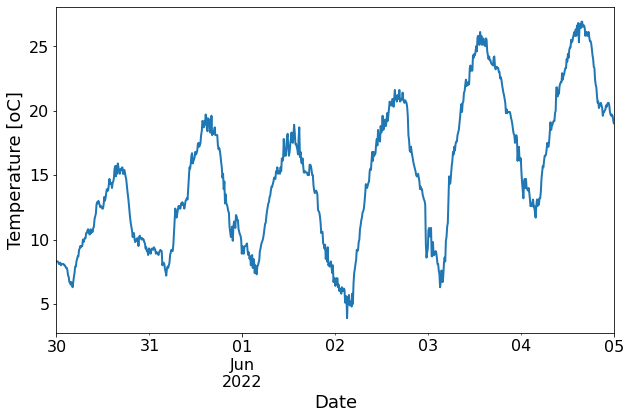

In [23]:
# Plot der Temperature-Daten

ax = temps.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Temperature [oC]")

In [24]:
# Koeln Irradiance Data

# https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/recent/

# https://pvlib-python.readthedocs.io/en/v0.8.0/generated/pvlib.pvsystem.sapm_effective_irradiance.html
# effective_irradiance (numeric) – Effective irradiance accounting for reflections and spectral content. 
# [W/m2]

# GS10: 10min-sum of solar incoming radiation [J/cm^2]

df_solarradiance = pd.read_csv('../data/produkt_zehn_min_sd_20201212_20220614_02667.txt', sep=";") 
df_solarradiance

STATIONS_ID    MESS_DATUM    QN  DS_10  GS_10  SD_10  LS_10  eor
0             2667  202012120000     3    0.0    0.0    0.0   -999  eor
1             2667  202012120010     3    0.0    0.0    0.0   -999  eor
2             2667  202012120020     3    0.0    0.0    0.0   -999  eor
3             2667  202012120030     3    0.0    0.0    0.0   -999  eor
4             2667  202012120040     3    0.0    0.0    0.0   -999  eor
...            ...           ...   ...    ...    ...    ...    ...  ...
79195         2667  202206142310     2    0.0    0.0    0.0   -999  eor
79196         2667  202206142320     2    0.0    0.0    0.0   -999  eor
79197         2667  202206142330     2    0.0    0.0    0.0   -999  eor
79198         2667  202206142340     2    0.0    0.0    0.0   -999  eor
79199         2667  202206142350     2    0.0    0.0    0.0   -999  eor

[79200 rows x 8 columns]

In [25]:
#daten in excel analysieren, welche daten ist relevant
#df_solarradiance.to_csv('koeln_solar.csv', index=False)

In [26]:
# J/cm2 = Ws/cm2 -> W/m2
# Ws/(cm2*10min*60s/min)

# GS_10: [J/cm2] = [W/m2] *10000/(10*60)

# Daten zwischen 30.05.2022 und 06.06.2022 auswählen

df_solarradiance_1week = df_solarradiance.drop(df_solarradiance.index[0:76896])
df_solarradiance_1week_2 = df_solarradiance_1week.drop(df_solarradiance.index[77761:79200])
df_solarradiance_1week_2 = df_solarradiance_1week_2.reset_index(drop=True)
df_solarradiance_1week_2.sample(10)

STATIONS_ID    MESS_DATUM    QN  DS_10  GS_10  SD_10  LS_10  eor
703         2667  202206032110     3    0.0    0.0  0.000   -999  eor
391         2667  202206011710     3    7.4    7.5  0.000   -999  eor
63          2667  202205301030     3   33.5   33.9  0.000   -999  eor
673         2667  202206031610     3   14.9   15.1  0.000   -999  eor
259         2667  202205311910     3    0.0    0.0  0.000   -999  eor
455         2667  202206020350     3    0.5    0.5  0.000   -999  eor
536         2667  202206021720     3    3.8   17.8  0.167   -999  eor
223         2667  202205311310     3   25.3   28.9  0.017   -999  eor
116         2667  202205301920     3    0.3    0.3  0.000   -999  eor
538         2667  202206021740     3    3.4   14.5  0.167   -999  eor

In [27]:
solar_irradiance = df_solarradiance_1week_2["GS_10"]*10000/(10*60) #[W/m2]

Text(0.5, 0, 'Date')

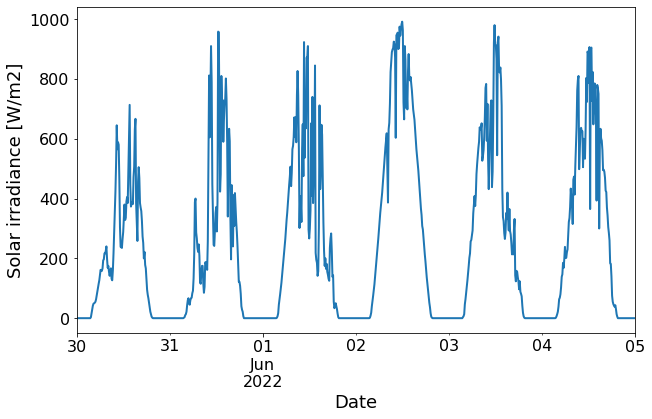

In [28]:
solar_irradiance = solar_irradiance.to_numpy()
dwd_irradiance = pd.Series(solar_irradiance, index=times_loc)
ax = dwd_irradiance.plot()
ax.set_ylabel("Solar irradiance [W/m2]")
ax.set_xlabel("Date")

In [29]:
#dwd_irradiance

## PV-Data Simulieren

Text(0.5, 0, 'Date')

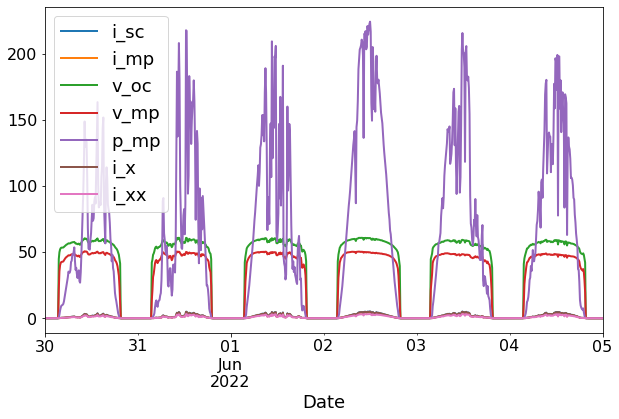

In [30]:
#SAPM Function is used

module = sandia_module

sapm_1 = pvlib.pvsystem.sapm(dwd_irradiance, temps, module)

ax = sapm_1.plot()
ax.set_xlabel("Date")
#ax.set_ylabel("Temperature [oC]")

# PV-Data Simulieren 1 Jahr

In [31]:
tus = Location(50.9375, 6.9603, 'Europe/Berlin', 200, 'Tucson') 

times_loc_2 = pd.date_range(start=datetime.datetime(2021,1,1), end=datetime.datetime(2022,1,1), 
                          freq='600s', tz=tus.tz)

In [32]:
# Air Temperature
df_1jahr = df[df['MESS_DATUM'] > 202101000000]
df_1jahr = df_1jahr[df_1jahr['MESS_DATUM'] < 202201010010]
df_1jahr

STATIONS_ID    MESS_DATUM    QN   PP_10  TT_10  TM5_10  RF_10  TD_10  \
3888          2667  202101010000     3   992.8    2.0     1.9   97.6    1.7   
3889          2667  202101010010     3   992.8    2.0     1.9   97.6    1.7   
3890          2667  202101010020     3   992.8    2.0     1.9   97.5    1.7   
3891          2667  202101010030     3   993.1    2.0     1.9   97.6    1.7   
3892          2667  202101010040     3   993.1    2.0     1.9   97.6    1.7   
...            ...           ...   ...     ...    ...     ...    ...    ...   
56444         2667  202112312320     3  1012.9   12.6    11.6   88.2   10.7   
56445         2667  202112312330     3  1012.9   12.6    11.5   88.2   10.7   
56446         2667  202112312340     3  1012.9   12.5    11.4   88.2   10.6   
56447         2667  202112312350     3  1012.8   12.6    11.4   87.1   10.5   
56448         2667  202201010000     3  1012.8   12.7    11.5   86.2   10.5   

       eor  
3888   eor  
3889   eor  
3890   eor  
3891   eor  
3892   eor  
...    ...  
56444  eor  
56445  eor  
56446  eor  
56447  eor  
56448  eor  

[52561 rows x 9 columns]

In [33]:
#https://www.pveducation.org/pvcdrom/modules-and-arrays/nominal-operating-cell-temperature
# Cell Temperature

NOCT = 48 #oC Nominal Operating Cell Temperature
S = 40 #mW/cm2 || S = insolation in mW/cm2

koelntemp_1jahr_air = df_1jahr["TT_10"].to_numpy()
koelntemp_1jahr = koelntemp_1jahr_air + (NOCT-20)/80 * S


Text(0, 0.5, 'Cell Temperature [oC]')

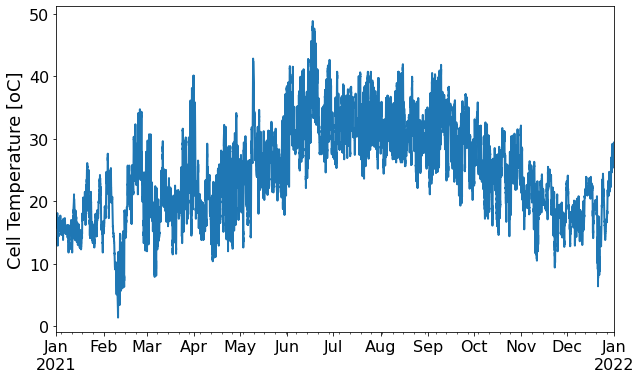

In [34]:
#temperature cell  fuer pvlib simulation
temps_1jahr = pd.Series(koelntemp_1jahr, index=times_loc_2)
ax_temp = temps_1jahr.plot()
ax_temp.set_ylabel("Cell Temperature [oC]")

In [35]:
df_solarradiance_1jahr = df_solarradiance[df_solarradiance['MESS_DATUM'] > 202101000000]
df_solarradiance_1jahr = df_solarradiance_1jahr[df_solarradiance_1jahr['MESS_DATUM'] < 202201010010]

df_solarradiance_1jahr

STATIONS_ID    MESS_DATUM    QN  DS_10  GS_10  SD_10  LS_10  eor
2880          2667  202101010000     3    0.0    0.0    0.0   -999  eor
2881          2667  202101010010     3    0.0    0.0    0.0   -999  eor
2882          2667  202101010020     3    0.0    0.0    0.0   -999  eor
2883          2667  202101010030     3    0.0    0.0    0.0   -999  eor
2884          2667  202101010040     3    0.0    0.0    0.0   -999  eor
...            ...           ...   ...    ...    ...    ...    ...  ...
55436         2667  202112312320     3    0.0    0.0    0.0   -999  eor
55437         2667  202112312330     3    0.0    0.0    0.0   -999  eor
55438         2667  202112312340     3    0.0    0.0    0.0   -999  eor
55439         2667  202112312350     3    0.0    0.0    0.0   -999  eor
55440         2667  202201010000     3    0.0    0.0    0.0   -999  eor

[52561 rows x 8 columns]

In [36]:
df_solarradiance_1jahr[df_solarradiance_1jahr["GS_10"] < 0] = 0

Text(0.5, 0, 'Date')

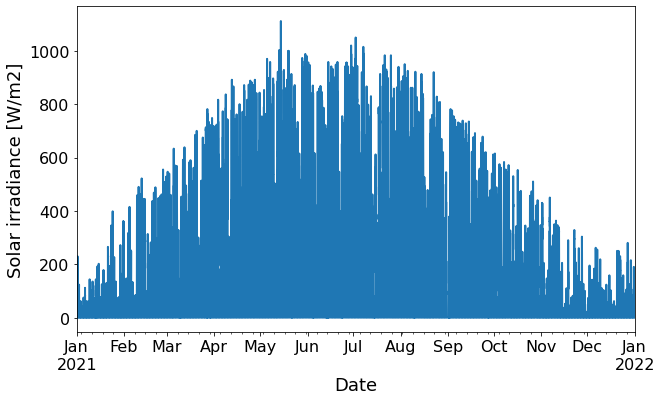

In [37]:
solar_irradiance_1jahr = df_solarradiance_1jahr["GS_10"]*10000/(10*60) #[W/m2]

#df_solarradiance_1jahr = df_solarradiance[df_solarradiance['MESS_DATUM'] > 202101000000]


solar_irradiance_1jahr = solar_irradiance_1jahr.to_numpy()
dwd_irradiance_1jahr = pd.Series(solar_irradiance_1jahr, index=times_loc_2)

ax = dwd_irradiance_1jahr.plot()
ax.set_ylabel("Solar irradiance [W/m2]")
ax.set_xlabel("Date")

## Module 1

Text(0.5, 0, 'Date')

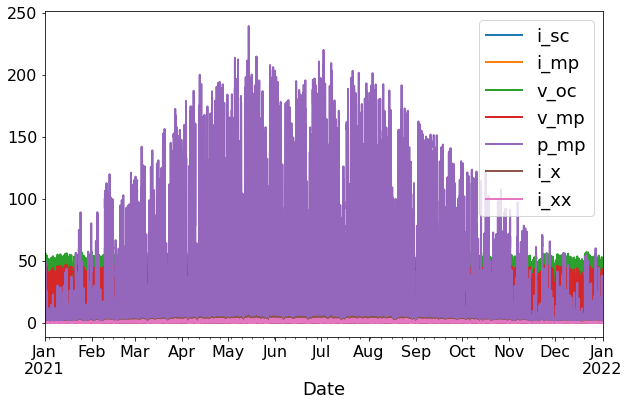

In [38]:
# SAPM Function is used
# https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.sapm.html#pvlib.pvsystem.sapm
# King, D. et al, 2004, “Sandia Photovoltaic Array Performance Model”, SAND Report 3535, Sandia National Laboratories, Albuquerque, NM. 

module = sandia_module

sapm_1 = pvlib.pvsystem.sapm(dwd_irradiance_1jahr, temps_1jahr, module)

ax = sapm_1.plot()
ax.set_xlabel("Date")
#ax.set_ylabel("Temperature [oC]")

## Module 2

In [39]:
module_2 = sandia_modules.Silevo_Triex_U300_Black__2014_
module_2

Vintage                                                          2014
Area                                                             1.68
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                            5.771
Voco                                                          68.5983
Impo                                                            5.383
Vmpo                                                          55.4547
Aisc                                                           0.0003
Aimp                                                          -0.0003
C0                                                              0.995
C1                                                              0.005
Bvoco                                                         -0.1913
Mbvoc               

Text(0.5, 0, 'Date')

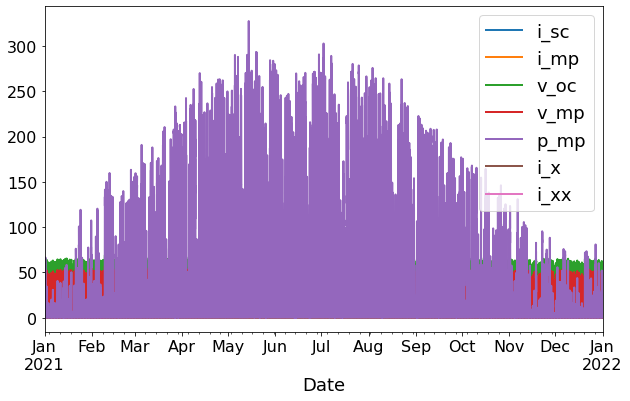

In [40]:
sapm_2 = pvlib.pvsystem.sapm(dwd_irradiance_1jahr, temps_1jahr, module_2)


ax2 = sapm_2.plot()
ax2.set_xlabel("Date")
#ax.set_ylabel("Temperature [oC]")

# Daten Plausibierung

## Irradiance

In [41]:
irradiance_de = (dwd_irradiance_1jahr.sum()/6)
print("Solar Irradiance: " + str(irradiance_de*10**-3) + " kWh/m2.a" ) #nur Sommerbestrahlung genommen

Solar Irradiance: 1003.9527777777779 kWh/m2.a


average annual total of horizontal **global irradiation in Germany 1088 kWh/m2** \
[1] : Recent Facts about Photovoltaics in Germany, Harry Wirth, Fraunhofer ISE,
download from https://www.ise.fraunhofer.de/en/publications/studies/recent-factsabout-pv-in-germany.html, version of May 15, 2021


### Module 1

In [42]:
Stromertrag = (sapm_1["p_mp"].sum()/6)*10**-3 #kWh/a
print("Jahresertrag des PVs: " + str(Stromertrag) + "kWh/a" )

Jahresertrag des PVs: 205.21392047445897kWh/a


In [43]:
Leistung = Stromertrag/(1650) *1000 #Wp
print("Leistung des PVs: " + str(Leistung) + " Wp" )
## 1650 = Durchschnitt Sonnenstunden in DE (Statista)
#(https://de.statista.com/statistik/daten/studie/249925/umfrage/sonnenstunden-im-jahr-nach-bundeslaendern/#:~:text=Mit%20durchschnittlich%201.650%20Sonnenstunden%20in,von%2010%2C5%20Grad%20Celsius)

Leistung des PVs: 124.37207301482361 Wp


In [44]:
A_PV = 1.7 #m2
Leistung_pro_flaeche = Leistung/A_PV
print("Leistung pro Fläche des PVs: " + str(Leistung_pro_flaeche) + " W/m2" )

Leistung pro Fläche des PVs: 73.16004294989625 W/m2


### Module 2

In [45]:
Stromertrag_2 = (sapm_2["p_mp"].sum()/6)*10**-3 #kWh/a
print("Jahresertrag des PVs: " + str(Stromertrag_2) + "kWh/a" )

Jahresertrag des PVs: 280.54897367052405kWh/a


In [46]:
Leistung_2 = Stromertrag_2/(1650) *1000 #kWp
print("Leistung des PVs: " + str(Leistung_2) + " Wp" )
## 1650 = Durchschnitt Sonnenstunden in DE (Statista)
#(https://de.statista.com/statistik/daten/studie/249925/umfrage/sonnenstunden-im-jahr-nach-bundeslaendern/#:~:text=Mit%20durchschnittlich%201.650%20Sonnenstunden%20in,von%2010%2C5%20Grad%20Celsius)

Leistung des PVs: 170.02968101243883 Wp


In [47]:
A_PV_2 = 1.68 #m2
Leistung_pro_flaeche_2 = Leistung_2/A_PV_2
print("Leistung pro Fläche des PVs: " + str(Leistung_pro_flaeche_2) + " W/m2" )

Leistung pro Fläche des PVs: 101.20814345978502 W/m2


***
**PV Kalkulation:**
- 166.67 W/m2
- 1 kWp -> 800 - 1000 kWh

Quelle: https://www.ess-kempfle.de/ratgeber/ertrag-photovoltaik-solaranlage/

## Modul Datenblatt

1. Module 1
http://www.solardesigntool.com/components/module-panel-solar/Canadian-Solar/832/CS5P-220M/specification-data-sheet.html

2. Module 2 http://www.solardesigntool.com/components/module-panel-solar/Silevo/2272/Triex-U300-Black/specification-data-sheet.html



In [48]:
# Module 1
P = 200 #W
Stunden_im_Jahr = 1650 #h
E = P*Stunden_im_Jahr *10**-3 #kWh/a
print("Jahresertrag des PVs: " + str(E) + "kWh/a" )

Jahresertrag des PVs: 330.0kWh/a


In [49]:
# Module 2
P_2 = 280 #W

E_2 = P_2*Stunden_im_Jahr *10**-3 #kWh/a
print("Jahresertrag des PVs: " + str(E_2) + "kWh/a" )

Jahresertrag des PVs: 462.0kWh/a


Text(0, 0.5, 'Jahresertrag [kWh/a]')

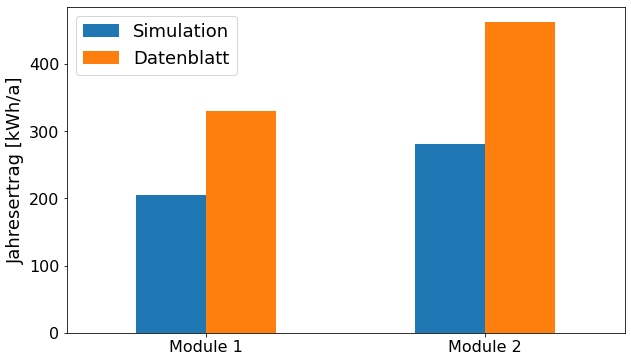

In [50]:
x1 = [Stromertrag, Stromertrag_2]
x2 = [E, E_2]
index = ['Module 1', 'Module 2']
df_plot = pd.DataFrame({'Simulation': x1,
                   'Datenblatt': x2}, index=index)
ax_plot = df_plot.plot.bar(rot=0)
ax_plot.set_ylabel("Jahresertrag [kWh/a]")

In [51]:
df_plot

Simulation  Datenblatt
Module 1  205.213920       330.0
Module 2  280.548974       462.0

In [52]:
# PV-Daten Exportieren

#sapm_1.to_csv('sapm_DWD.csv', index=False) 

____________

<AxesSubplot:>

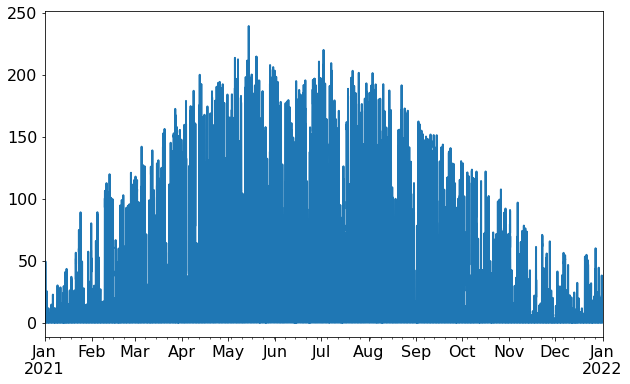

In [53]:
sapm_1["p_mp"].plot()

# Inverter

The Right Inverter for Every Plant
A large number of PV inverters is available on the market – but the devices are classified on the basis of three important characteristics: power, DC-related design, and circuit topology.

**1. Power** \
The available power output starts at two kilowatts and extends into the megawatt range. Typical outputs are 5 kW for private home rooftop plants, 10 – 20 kW for commercial plants (e.g., factory or barn roofs) and 500 – 800 kW for use in PV power stations.

**2. Module wiring.** \
The DC-related design concerns the wiring of the PV modules to the inverter. In this connection, distinctions are made between string, multistring and central inverters, whereby the term "string" refers to a string of modules connected in series. Multistring inverters have two or more string inputs, each with its own MPP tracker (Maximum Power Point, see below). These make a particularly sensible choice when the PV array consists of differently oriented subareas or is partially shaded. Central inverters only have one MPP tracker despite a relatively higher power output. They are especially well-suited for large-scale plants with a homogeneous generator.

**3. Circuit topology** \
With regard to circuit topology, distinctions are made between one- and three-phase inverters, and between devices with and without transformers. One-phase inverters are usually used in small plants, in large PV plants either a network consisting of several one-phase inverters or three-phase inverters have to be used on account of the unbalanced load of 4.6 kVA. However, transformers serve the purpose of galvanic isolation (required in some countries) and make it possible to ground the PV module (necessary for some types of modules). Whenever possible, however, inverters without transformers are used. They are a little smaller and lighter than transformer devices and operate with a higher efficiency.

https://www.sma.de/en/partners/knowledgebase/pv-inverters-basic-facts-for-planning-pv-systems.html


## Wechselrichter Liste

In [54]:
inverters = pvsystem.retrieve_sam('sandiainverter')
inverters

ABB__MICRO_0_25_I_OUTD_US_208__208V_  \
Vac                                        208   
Pso                                   2.089607   
Paco                                     250.0   
Pdco                                259.588593   
Vdco                                      40.0   
C0                                   -0.000041   
C1                                   -0.000091   
C2                                    0.000494   
C3                                   -0.013171   
Pnt                                      0.075   
Vdcmax                                    50.0   
Idcmax                                6.489715   
Mppt_low                                  30.0   
Mppt_high                                 50.0   
CEC_Date                                   NaN   
CEC_Type                   Utility Interactive   

          ABB__MICRO_0_25_I_OUTD_US_240__240V_  \
Vac                                        240   
Pso                                   2.240412   
Paco                                     250.0   
Pdco                                259.492065   
Vdco                                      40.0   
C0                                   -0.000039   
C1                                   -0.000132   
C2                                    0.002418   
C3                                   -0.014926   
Pnt                                      0.075   
Vdcmax                                    50.0   
Idcmax                                6.487302   
Mppt_low                                  30.0   
Mppt_high                                 50.0   
CEC_Date                                   NaN   
CEC_Type                   Utility Interactive   

          ABB__MICRO_0_3_I_OUTD_US_208__208V_  \
Vac                                       208   
Pso                                  1.846506   
Paco                                    300.0   
Pdco                                311.66925   
Vdco                                     40.0   
C0                                  -0.000033   
C1                                  -0.000192   
C2                                   0.000907   
C3                                  -0.031742   
Pnt                                      0.09   
Vdcmax                                   50.0   
Idcmax                               7.791731   
Mppt_low                                 30.0   
Mppt_high                                50.0   
CEC_Date                                  NaN   
CEC_Type                  Utility Interactive   

          ABB__MICRO_0_3_I_OUTD_US_240__240V_  \
Vac                                       240   
Pso                                  1.950539   
Paco                                    300.0   
Pdco                               311.580872   
Vdco                                     40.0   
C0                                  -0.000034   
C1                                  -0.000256   
C2                                   0.002453   
C3                                  -0.028223   
Pnt                                      0.09   
Vdcmax                                   50.0   
Idcmax                               7.789522   
Mppt_low                                 30.0   
Mppt_high                                50.0   
CEC_Date                                  NaN   
CEC_Type                  Utility Interactive   

          ABB__MICRO_0_3HV_I_OUTD_US_208__208V_  \
Vac                                         208   
Pso                                    1.769444   
Paco                                      300.0   
Pdco                                 312.421082   
Vdco                                       45.0   
C0                                    -0.000045   
C1                                    -0.000196   
C2                                     0.001959   
C3                                    -0.023725   
Pnt                                        0.09   
Vdcmax                                     60.0   
Idcmax                      

In [55]:
## in Excel die Liste exportieren
#inverters.to_csv('inverters_pvlib.csv', index=False) 

Text(0, 0.5, 'V')

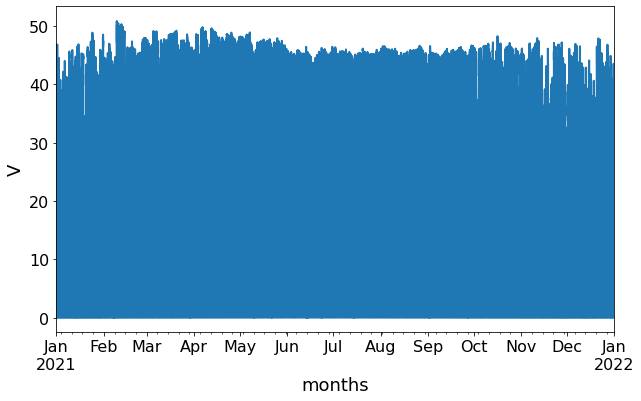

In [56]:
ax = sapm_1["v_mp"].plot()
ax.set_xlabel("months")
ax.set_ylabel("V")

Text(0, 0.5, 'W')

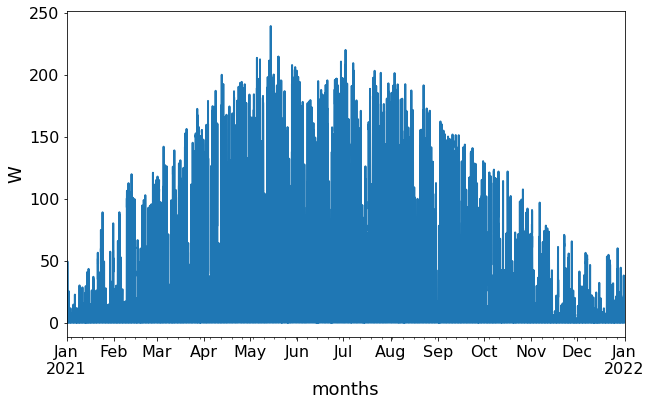

In [57]:
ax = sapm_1["p_mp"].plot()
ax.set_xlabel("months")
ax.set_ylabel("W")

## 2 Wechselrichter vergleichen

In [58]:
# 1 Kleiner Wechselrichter
inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

Vac                          208
Pso                     2.089607
Paco                       250.0
Pdco                  259.588593
Vdco                        40.0
C0                     -0.000041
C1                     -0.000091
C2                      0.000494
C3                     -0.013171
Pnt                        0.075
Vdcmax                      50.0
Idcmax                  6.489715
Mppt_low                    30.0
Mppt_high                   50.0
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__MICRO_0_25_I_OUTD_US_208__208V_, dtype: object

In [59]:
# 2 Großer Wechselrichter
inverters['ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_']

Vac                          208
Pso                    46.863808
Paco                     10000.0
Pdco                10488.306641
Vdco                       320.0
C0                     -0.000003
C1                     -0.000036
C2                      0.000305
C3                     -0.002351
Pnt                          0.1
Vdcmax                     416.0
Idcmax                 32.775958
Mppt_low                   220.0
Mppt_high                  416.0
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_, dtype: object

### 1 Modul 1 Wechselrichter

<img src="../img/pv1modul.png" alt="inv1" width="200"/>

In [60]:
inverter_module = inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

modul1_klein_inv = pvlib.inverter.sandia(sapm_1["v_mp"], sapm_1["p_mp"], inverter=inverter_module)

<AxesSubplot:>

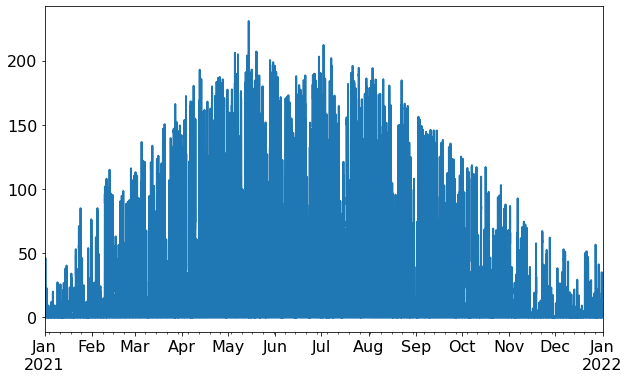

In [61]:
modul1_klein_inv.plot()

In [62]:
modul1_Jahr = (modul1_klein_inv.sum()/6)*10**-3 #kWh/a
print("Jahresertrag des PVs: " + str(modul1_Jahr) + "kWh/a" )

Jahresertrag des PVs: 192.16180394350997kWh/a


In [63]:
eta_1 = modul1_Jahr/Stromertrag
print("die Effizienz des Wechselrichters: " + str(eta_1*100) + "%" )

die Effizienz des Wechselrichters: 93.63975089956264%


In [64]:
inverter_module_2 = inverters['ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_']

modul1_gross_inv = pvlib.inverter.sandia(sapm_1["v_mp"], sapm_1["p_mp"], inverter=inverter_module_2)

<AxesSubplot:>

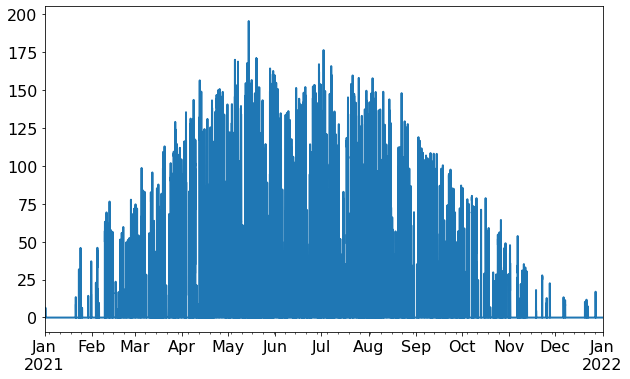

In [65]:
modul1_gross_inv.plot()

In [66]:
modul1_Jahr_inv2 = (modul1_gross_inv.sum()/6)*10**-3 #kWh/a

In [67]:
eta_2 = modul1_Jahr_inv2/Stromertrag
print("die Effizienz des Wechselrichters: " + str(eta_2*100) + "%" )

die Effizienz des Wechselrichters: 44.24543944193241%


### 3 Module in Serien

<AxesSubplot:>

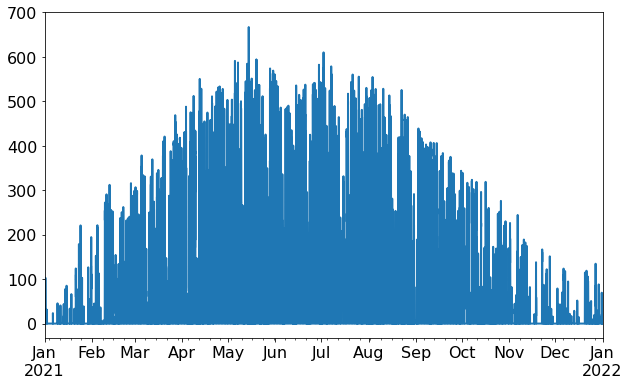

In [68]:
modul1_gross_inv_2 = pvlib.inverter.sandia(sapm_1["v_mp"]*3, sapm_1["p_mp"]*3, inverter=inverter_module_2)
modul1_gross_inv_2.plot()

In [69]:
(modul1_gross_inv_2.sum()/6)*10**-3 #kWh/a

462.58905474640585

In [70]:
inverter_module = inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

modul1_klein_inv_2 = pvlib.inverter.sandia(sapm_1["v_mp"]*3, sapm_1["p_mp"]*3, inverter=inverter_module)

In [71]:
(modul1_klein_inv_2.sum()/6)*10**-3 #kWh/a

488.4873275987151

<AxesSubplot:>

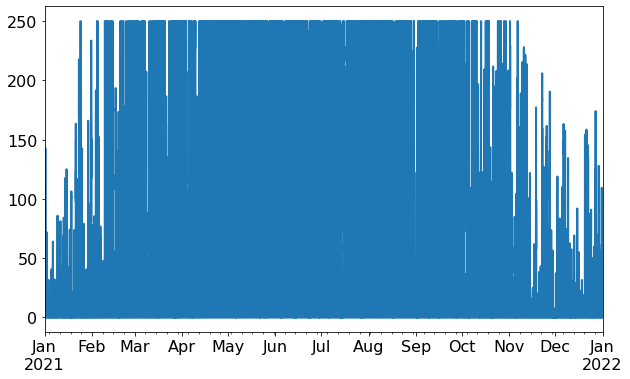

In [72]:
modul1_klein_inv_2.plot()

### 5 Module 1 Wechselrichter

<img src="../img/pv5string.png" alt="inv1_5" width="500"/>

In [73]:
inverter_module = inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

modul1_klein_inv_3= pvlib.inverter.sandia(sapm_1["v_mp"]*5, sapm_1["p_mp"]*5, inverter=inverter_module)
fuenftmodul_inv = (modul1_klein_inv_3.sum()/6)*10**-3 #kWh/a

print("Jahresertrag des PVs: " + str(fuenftmodul_inv) + "kWh/a" )

Jahresertrag des PVs: 615.7184622354001kWh/a


In [74]:
dc_leistung_5 = sapm_1["p_mp"]*5

eta_2 = fuenftmodul_inv/((dc_leistung_5.sum()/6)*10**-3)
print("die Effizienz des Wechselrichters: " + str(eta_2*100) + "%" )

die Effizienz des Wechselrichters: 60.00747520556558%


<AxesSubplot:>

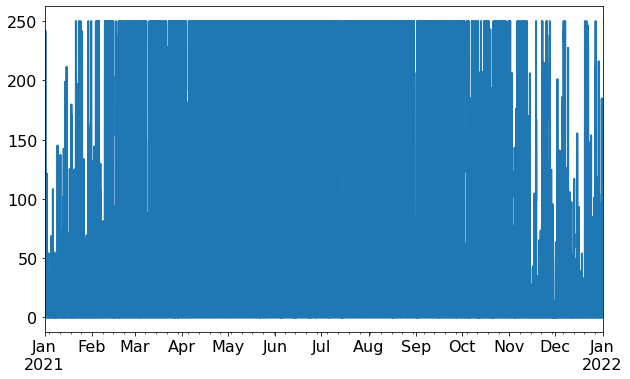

In [75]:
modul1_klein_inv_3.plot()

In [76]:
modul1_gross_inv_3 = pvlib.inverter.sandia(sapm_1["v_mp"]*5, sapm_1["p_mp"]*5, inverter=inverter_module_2)

fuenftmodul_inv = (modul1_gross_inv_3.sum()/6)*10**-3 #kWh/a
dc_Leistung_5_2 = sapm_1["p_mp"]*5
print("Jahresertrag des PVs: " + str(fuenftmodul_inv) + "kWh/a" )

Jahresertrag des PVs: 852.7218361225679kWh/a


In [77]:
eta_3 = fuenftmodul_inv/((dc_Leistung_5_2.sum()/6)*10**-3)
print("die Effizienz des Wechselrichters: " + str(eta_3*100) + "%" )

die Effizienz des Wechselrichters: 83.10565230185718%


<AxesSubplot:>

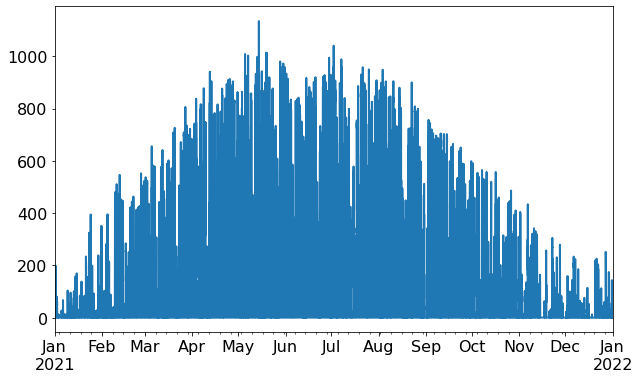

In [78]:
modul1_gross_inv_3.plot()

# Literatures

King, D. et al, 2004, “Sandia Photovoltaic Array Performance Model”, SAND Report 3535, Sandia National Laboratories, Albuquerque, NM.
https://digital.library.unt.edu/ark:/67531/metadc888150/m2/1/high_res_d/919131.pdf